In [8]:
import sys
sys.path.append("..")

import numpy as np
import time
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd

from methods.range_search.hierarchy import *
from methods.range_search.kdtree import *
from methods.range_search.rtree_impl import *
from ranges.stripe_range import StripeRange

Helpers

In [2]:
def build_indices(n, dim):
    points = np.random.zipf(1.5, size=(n, dim))

    # Hierarchical
    hie = HierarchicalIndex(points=points, decay=4)
    hie.build_index()
    hie.find_coverage()
    hie.find_neighbor_stats()

    # KDTree
    kdtree = KDTree(points=points)

    # RTree
    rtree = RTree(dimensions=dim)
    rtree.insert_points(points)

    return {
        "hierarchical": lambda q: hie.query(q),
        "kdtree": lambda q: kdtree.query(q),
        "rtree": lambda q: rtree.query(q)
    }, points

In [3]:
def sample_query(points, width):
    return StripeRange.sample_stripe(points, r=width, tolerance=0.001)

In [4]:
def get_recall(results, gt):
    return len(results) / len(gt) if len(gt) > 0 else 1.0

In [6]:
def round_to_nearest_power_fraction(arr):
    """
    Round each element in arr to the nearest 1 / (2^i) for i = 1, 2, ..., such that 1/(2^i) < 1.
    Assumes all elements in arr are in (0,1).
    """
    powers = np.array([1 / (2 ** i) for i in range(1, 20)])  # Adjust range if needed
    arr = np.asarray(arr)

    def nearest_fraction(x):
        diffs = np.abs(powers - x)
        return powers[np.argmin(diffs)]

    return np.vectorize(nearest_fraction)(arr)

Different dimensions

In [ ]:
n = 10000
dims = [2, 4, 8]
repeat = 5
widths = [
    1 / 2,
    1 / 4,
    1 / 8,
    1 / 16,
    1 / 32,
    1 / 64,
    1 / 128,
    1 / 256,
    1 / 512,
]

results = {}

for d in dims:
    fns, points = build_indices(n, d)

    for width in tqdm(widths, desc=f"Width {d}D"):
        query = sample_query(points, width=width)

        # linear search
        start_time = time.time()
        for _ in range(repeat):
            gt = linear_search(points, query)
        elapsed_time = time.time() - start_time
        results.setdefault("linear_time", []).append(elapsed_time / repeat)

        for method, fn in fns.items():
            print("Running method:", method)
            if method == "linear":
                continue
            start_time = time.time()
            for _ in range(repeat):
                res = fn(query)
            elapsed_time = time.time() - start_time
            results.setdefault(f"{method}_time", []).append(elapsed_time / repeat)
            recall = get_recall(res, gt)
            results.setdefault(f"{method}_recall", []).append(recall)

        results.setdefault("widths", []).append(width)
        results.setdefault("dimensions", []).append(d)
        results.setdefault("n", []).append(n)

In [ ]:
results = pd.DataFrame(results)
results["frac"] = round_to_nearest_power_fraction(results["widths"])

Visualization

In [109]:
results = pd.read_csv("assets/range_search_dim_3.csv")

In [110]:
results["dimensions"].value_counts()

dimensions
64     9
128    9
Name: count, dtype: int64

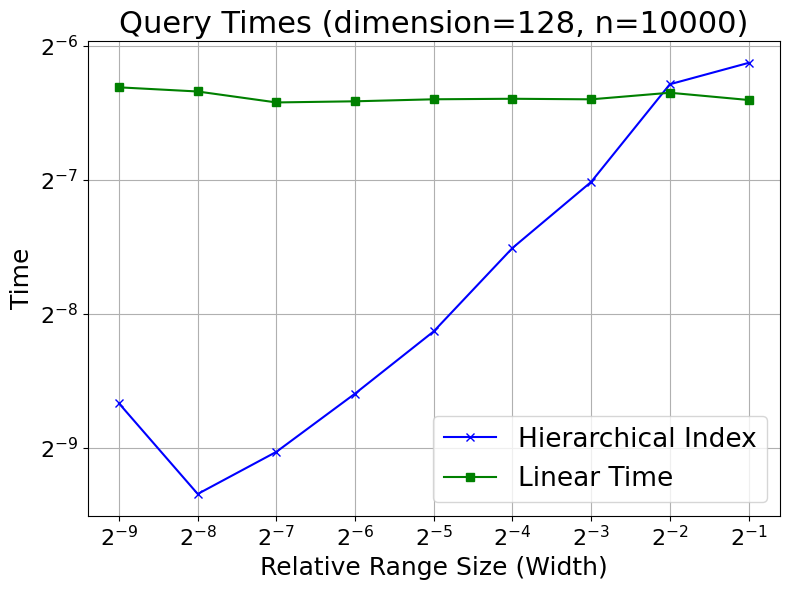

In [ ]:
d = 128
df = results[results["dimensions"] == d]

# Group by frac and compute mean times
grouped = df.groupby("frac").mean(numeric_only=True)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(
    grouped.index, grouped["hierarchical_time"], marker="x", label="Hierarchical Index", color='blue'
)
# plt.plot(grouped.index, grouped["rtree_time"], marker="o", label="R-Tree", color='orange')
plt.plot(grouped.index, grouped["linear_time"], marker="s", label="Linear Time", color='green')
# plt.plot(grouped.index, grouped["kdtree_time"], marker="^", label="KD-Tree", color='red')

# Formatting
plt.xlabel("Relative Range Size (Width)", fontsize=18)
plt.ylabel("Time", fontsize=18)
plt.title(f"Query Times (dimension={d}, n={n})", fontsize=22)
plt.legend(fontsize=19)
plt.grid(True)
plt.xscale("log", base=2)
plt.yscale("log", base=2)
plt.xticks(fontsize=16)  # You can adjust the number as needed
plt.yticks(fontsize=16)
plt.tight_layout()
# plt.savefig(f'assets/range_search_dim_{d}.png')
plt.show()

Different sizes of input:

In [ ]:
ns = [10000, 20000, 40000, 80000, 160000]
d = 4
repeat = 5
widths = [
    1 / 2,
    1 / 4,
    1 / 8,
    1 / 16,
    1 / 32,
    1 / 64,
    1 / 128,
    1 / 256,
    1 / 512,
]

results = {}

for n in ns:
    fns, points = build_indices(n, d)

    for width in tqdm(widths, desc=f"Width {n} size"):
        query = sample_query(points, width=width)

        # linear search
        start_time = time.time()
        for _ in range(repeat):
            gt = linear_search(points, query)
        elapsed_time = time.time() - start_time
        results.setdefault("linear_time", []).append(elapsed_time / repeat)

        for method, fn in fns.items():
            print("Running method:", method)
            if method == "linear":
                continue
            start_time = time.time()
            for _ in range(repeat):
                res = fn(query)
            elapsed_time = time.time() - start_time
            results.setdefault(f"{method}_time", []).append(elapsed_time / repeat)
            recall = get_recall(res, gt)
            results.setdefault(f"{method}_recall", []).append(recall)

        results.setdefault("widths", []).append(width)
        results.setdefault("dimensions", []).append(d)
        results.setdefault("n", []).append(n)

visualize


In [122]:
results = pd.concat([
    # pd.read_csv("assets/range_search_size_1.csv"),
    # pd.read_csv("assets/range_search_size_2.csv"),
    # pd.read_csv("assets/range_search_size_3.csv"),
    pd.read_csv("assets/range_search_size_dim_128_1.csv"),
    pd.read_csv("assets/range_search_size_dim_128_2.csv"),
], ignore_index=True)

# results = pd.read_csv("assets/range_search_size_3.csv")
results.head()

,linear_time,hierarchical_time,hierarchical_recall,widths,dimensions,n,frac
0,0.012023,0.012079,1.0,0.50000,128,10000,0.50000
1,0.011940,0.011425,1.0,0.25000,128,10000,0.25000
2,0.012082,0.008634,1.0,0.12500,128,10000,0.12500
3,0.015695,0.004292,1.0,0.06250,128,10000,0.06250
4,0.011918,0.003161,1.0,0.03125,128,10000,0.03125


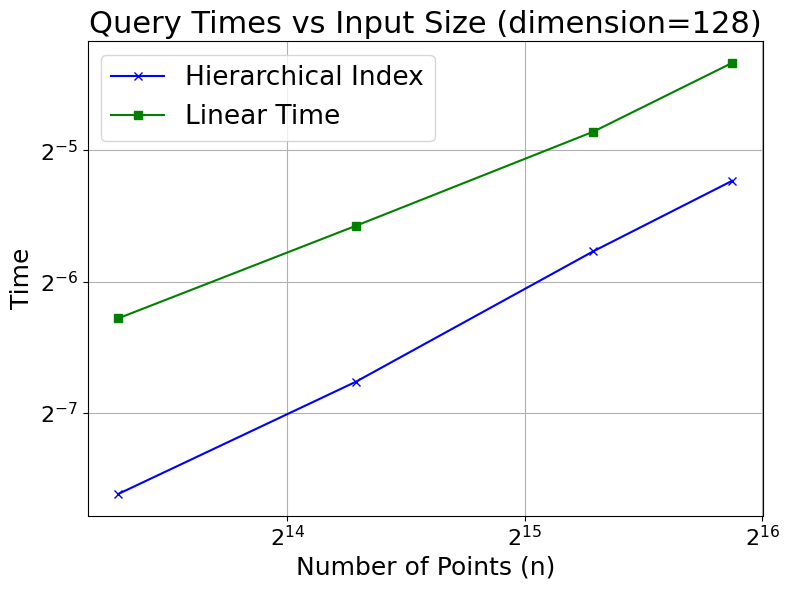

In [124]:
df = results
# Group by n and compute mean times
grouped_n = df.groupby("n").mean(numeric_only=True)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(
    grouped_n.index,
    grouped_n["hierarchical_time"],
    marker="x",
    label="Hierarchical Index",
    color="blue",
)
# plt.plot(
    # grouped_n.index, grouped_n["rtree_time"], marker="o", label="R-Tree", color="orange"
# )
plt.plot(
    grouped_n.index,
    grouped_n["linear_time"],
    marker="s",
    label="Linear Time",
    color="green",
)
# plt.plot(
    # grouped_n.index, grouped_n["kdtree_time"], marker="^", label="KD-Tree", color="red"
# )

# Formatting
plt.xlabel("Number of Points (n)", fontsize=18)
plt.ylabel("Time", fontsize=18)
plt.title(
    f"Query Times vs Input Size (dimension={results['dimensions'][0]})", fontsize=22
)
plt.legend(fontsize=19)
plt.grid(True)
plt.xscale("log", base=2)
plt.yscale("log", base=2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(f'assets/range_search_size_dim_{results["dimensions"][0]}.png')
plt.show()